# QKeras RNN comparison


1. Create a model and compare its performance to the boosted model
2. If the model outreach the performance of the boosted model : 
 -   create a model with the same feature with qkeras (QAT) and 
 -   quantized the keras model (PTQ)
3. Compare those two to PTQ boosted model

The models with keras should converge to around 1e-5 or 9.8e-6

For QKeras it's been somewhere around 1.1e-5 or so



# To Run Everytime

## Imports

In [1]:
import tensorflow as tf
import keras
import numpy as np
import time
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from collections import deque


from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *

import hls4ml
import nnlar
from nnlar.datashaper import DataShaper

2022-05-09 10:30:44.959602: I tensorflow/core/util/util.cc:168] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-05-09 10:30:44.965246: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-09 10:30:44.965270: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


name convert optimizers ['fuse_bias_add', 'remove_useless_transpose', 'output_rounding_saturation_mode', 'qkeras_factorize_alpha', 'extract_ternary_threshold', 'fuse_consecutive_batch_normalization'] File: flow.py Line: 23
name optimize optimizers ['eliminate_linear_activation', 'fuse_consecutive_batch_normalization', 'fuse_batch_normalization', 'replace_multidimensional_dense_with_conv'] File: flow.py Line: 23
vivado:merge_batch_norm_quantized_tanh Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:quantize_dense_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_config_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:optimize_pointwise_conv Get_Optimizer, optimizer/opti

/atlas/bonnet/hls4ml/hls4ml/hls4ml/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
# Load libraries if they are changed
%load_ext autoreload
%autoreload 2


## Data creation 

In [3]:
from nnlar.datashaper import DataShaper
ds = DataShaper.from_h5("../data/rdgap_mu140.h5")

x, x_val, x_test, y, y_val, y_test = ds()

shapes (1999995, 5, 1) (1999995, 1)
shapes (899992, 5, 1) (99995, 5, 1) (999998, 5, 1)


In [4]:
boosted_model =  tf.keras.models.load_model('pb_file')

boosted_model.summary()


2022-05-09 10:30:51.279590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-09 10:30:51.279629: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-09 10:30:51.279658: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martop): /proc/driver/nvidia/version does not exist
2022-05-09 10:30:51.280107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


## Settings

In [5]:
# settings of the networks 
output = 1

nbr_batch = 80
nbr_epoch = 500
lr=0.001

nbr_conv_epoch = 4 #number of epochs for the conversion 



def units(j): 
    return (j+2)*2
units_range = 5

In [6]:
#quantized settings
integer = 3

def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+2)*2

def bit_width(i): return {'bits': (i+2)*2, 'integer': integer, 'symmetric': 0, 'alpha':1}

bits_range = 5

In [7]:
# path

#path of the tested models 
def models_path(j) : return f"tests/models_test/epochs={nbr_epoch}/models_units={units(j)}_batch={nbr_batch}_lr={lr}.h5"

#path of the qconverted models
def qmodels_path(j, i): return f"tests/qmodels_test/qconverted/qmodels_units={units(j)}_epoch={nbr_conv_epoch}_batch={nbr_batch}_lr={lr},<{bit_lenghts(i)},{integer}>.h5"

#path of the qtrained models
def qtrained_models_path(j, i): return f"tests/qmodels_test/qtrained/qmodels_units={units(j)}_epoch={nbr_epoch}_batch={nbr_batch}_lr={lr},<{bit_lenghts(i)},{integer}>.h5"

#path of the qref models 
def qrefmodels_path (i) : return f"qmodels_epoch={nbr_conv_epoch}/qmodels<{bit_lenghts(i)},{integer}>.h5"

# 1. Creating a good network

## Training of the classic model

In [32]:
def normal_model (units_parameter):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=10, 
                                                    restore_best_weights=True, 
                                                    min_delta=0.000001,
                                                    mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=5, min_lr=0.000001, verbose=1)

    r_model = Sequential()
    r_model.add(SimpleRNN(units_parameter, input_shape=(5, 1), return_sequences=False, name='SimpleRNN'))
    r_model.add(Dense(output, activation='relu',name='dense'))
    r_model.compile(loss="mean_squared_error", optimizer=Adam(lr=0.001))


    r_model.summary()

    r_model.fit(x,y,validation_data=(x_val,y_val), epochs=nbr_epoch, batch_size=40, shuffle=True, callbacks=[early_stopping, reduce_lr])


    return r_model

def model_training (): 
    models =[]

    for j in range(units_range):
        units_parameter = units (j)
        model = normal_model(units_parameter)
        models.append(model)
        model.save(models_path(j))
        print('number of units ', units_parameter)          
    return models

models = model_training()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SimpleRNN (SimpleRNN)       (None, 4)                 24        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500


/atlas/bonnet/miniconda3/envs/hls4ml-tutorial/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22500/22500 [==============================] - 47s 2ms/step - loss: 8.7473e-04 - val_loss: 8.6983e-04 - lr: 0.0010
Epoch 2/500
22500/22500 [==============================] - 46s 2ms/step - loss: 8.7360e-04 - val_loss: 8.6983e-04 - lr: 0.0010
Epoch 3/500
22500/22500 [==============================] - 49s 2ms/step - loss: 8.7361e-04 - val_loss: 8.6983e-04 - lr: 0.0010
Epoch 4/500
22500/22500 [==============================] - 50s 2ms/step - loss: 8.7360e-04 - val_loss: 8.6983e-04 - lr: 0.0010
Epoch 5/500
22500/22500 [==============================] - 49s 2ms/step - loss: 8.7361e-04 - val_loss: 8.6983e-04 - lr: 0.0010
Epoch 6/500
22480/22500 [============================>.] - ETA: 0s - loss: 8.7361e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
22500/22500 [==============================] - 50s 2ms/step - loss: 8.7360e-04 - val_loss: 8.6983e-04 - lr: 0.0010
Epoch 7/500
22500/22500 [==============================] - 49s 2ms/step - loss: 8.7360e-04 - val_los

## Comparison with the reference model

31250/31250 [==============================] - 33s 1ms/step
mseref-msemodel =  -0.0008628192


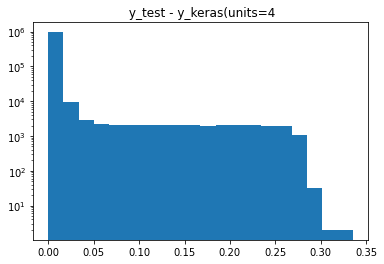

31250/31250 [==============================] - 33s 1ms/step
mseref-msemodel =  -5.5346227e-06


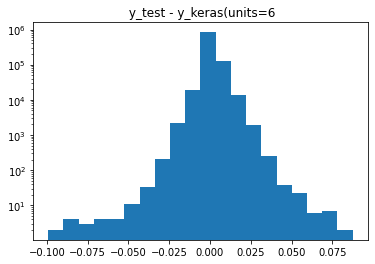

31250/31250 [==============================] - 33s 1ms/step
mseref-msemodel =  -3.0194396e-06


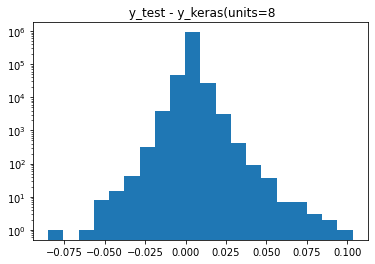

31250/31250 [==============================] - 33s 1ms/step
mseref-msemodel =  -0.0008628192


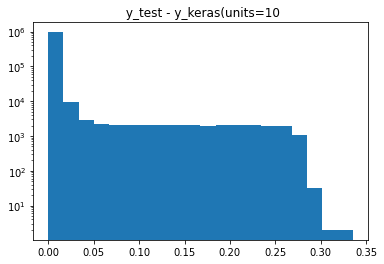

31250/31250 [==============================] - 32s 1ms/step
mseref-msemodel =  -3.589359e-06


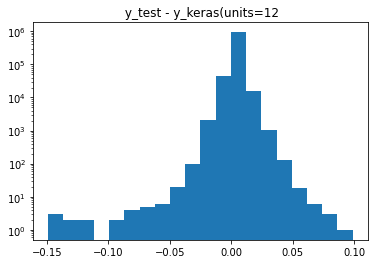

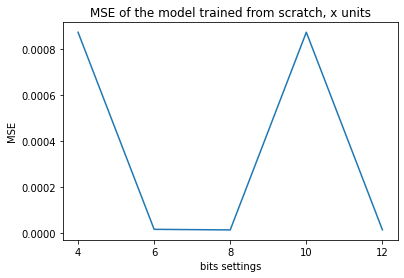

In [27]:
y_ref = boosted_model.predict(x_test)
loss1 = [] #contain the losses of the models with different units number
diff_loss = []  

unit_nbr = []

for j in range(units_range):
    model = tf.keras.models.load_model(models_path(j))
    unit_nbr.append(units(j))

    y_keras = model.predict(x_test)
    diff = mse(y_test, y_ref)-mse(y_test,y_keras)
    print('mseref-msemodel = ',diff)
    
    diff_loss.append(diff)
    loss1.append(mse(y_test,y_keras))
    

    plt.figure()
    plt.hist(y_test-y_keras, bins=20)
    plt.yscale('log')
    plt.title(f' y_test - y_keras(units={units(j)}')
    plt.show()
    
plt.figure()
plt.plot(loss1)
plt.xticks(np.arange(len(unit_nbr)), [f"{unit}" for unit in unit_nbr])
plt.xlabel('bits settings')
plt.ylabel('MSE')
plt.title(f'MSE of the model trained from scratch, x units')
plt.show()

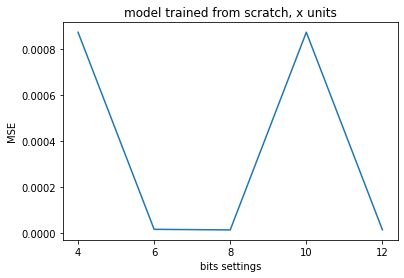

[-0.0008628192, -5.5346227e-06, -3.0194396e-06, -0.0008628192, -3.589359e-06]


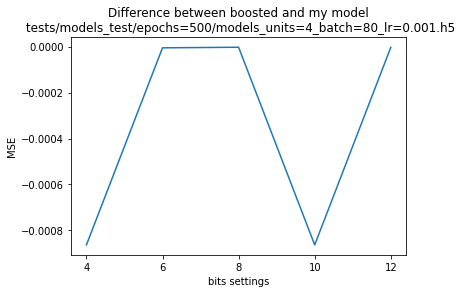

In [30]:
plt.figure()
plt.plot(loss1)
plt.xticks(np.arange(len(unit_nbr)), [f"{unit}" for unit in unit_nbr])
plt.xlabel('bits settings')
plt.ylabel('MSE')
plt.title(f'model trained from scratch, x units')
plt.show()

plt.figure()
plt.plot(diff_loss)
plt.xticks(np.arange(len(unit_nbr)), [f"{unit}" for unit in unit_nbr])
plt.xlabel('bits settings')
plt.ylabel('MSE')
plt.title(f'Difference between boosted and my model\n {models_path(0)}')
print (diff_loss)
plt.show()

# 2. Quantizing it 

## Quantization conversion

In [10]:
def quantized_conv_model (bits, units_parameter, model_to_convert):  

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=10, 
                                                    restore_best_weights=True, 
                                                    min_delta=0.000001,
                                                    mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=5, min_lr=0.000001, verbose=1)  
    qr_model = Sequential()

    qr_model.add(QSimpleRNN(units_parameter,
                        input_dim= 1,
                        activation='relu',
                        kernel_quantizer=quantized_bits(**bits),
                        recurrent_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)    
                        ))
       
    qr_model.add(QDense(output, 
                        activation='linear',
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits) ))

    qr_model.compile(loss="mse", optimizer=Adam(lr))
    
    qr_model.summary()
    #using the weight from the classic network as a base
    qr_model.set_weights(model_to_convert.get_weights())
    qr_model.fit(x, y, validation_data= (x_val,y_val),epochs = nbr_conv_epoch, batch_size=40, shuffle=True, callbacks=[early_stopping, reduce_lr])

    return qr_model

def qmodel_conv_training (): 

    qmodels =[]
    for i in range(bits_range):
        bits_parameter = bit_width(i)
        for j in range(units_range):
            qmodel = quantized_conv_model(bits_parameter, units(j), tf.keras.models.load_model(models_path(j)))
            qmodel.save(qmodels_path(j,i))
            qmodels.append(qmodel)
        print( 'bit width ', bits_parameter)        
    return qmodels
        
qmodels = qmodel_conv_training()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_simple_rnn_2 (QSimpleRNN)  (None, 4)                24        
                                                                 
 q_dense_2 (QDense)          (None, 1)                 5         
                                                                 
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
22500/22500 [==============================] - 55s 2ms/step - loss: 0.0070 - val_loss: 8.6983e-04 - lr: 0.0010
Epoch 2/4
22500/22500 [==============================] - 61s 3ms/step - loss: 0.0073 - val_loss: 8.6983e-04 - lr: 0.0010
Epoch 3/4
22500/22500 [==============================] - 61s 3ms/step - loss: 0.0074 - val_loss: 8.6983e-04 - lr: 0.0010
Epoch 4/4
22500/22500 [==============================] - 62s 3ms/step - loss: 0.0074 - val_

31250/31250 [==============================] - 33s 1ms/step


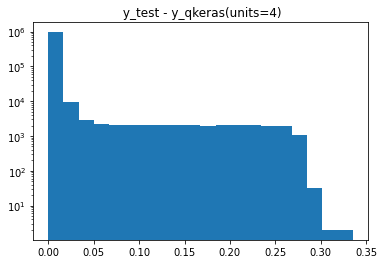

31250/31250 [==============================] - 31s 971us/step


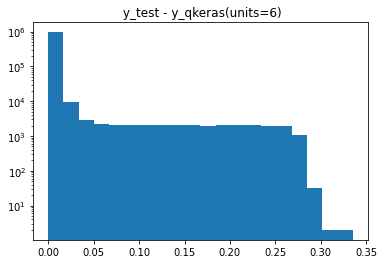

31250/31250 [==============================] - 32s 1ms/step


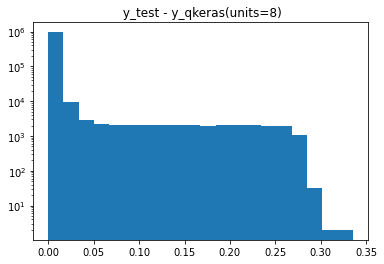

31250/31250 [==============================] - 33s 1ms/step


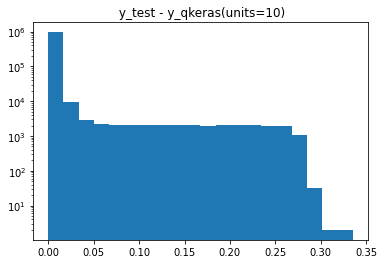

31250/31250 [==============================] - 32s 1ms/step


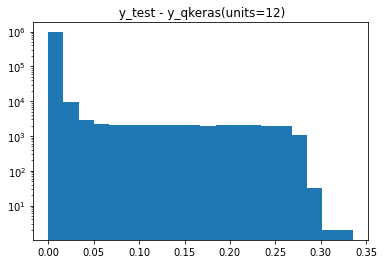

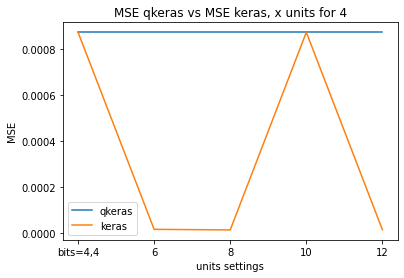

31250/31250 [==============================] - 33s 1ms/step


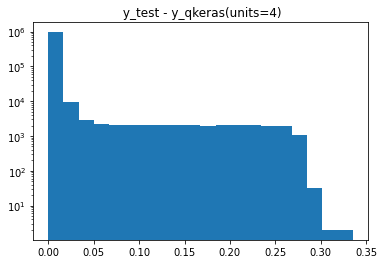

31250/31250 [==============================] - 33s 1ms/step


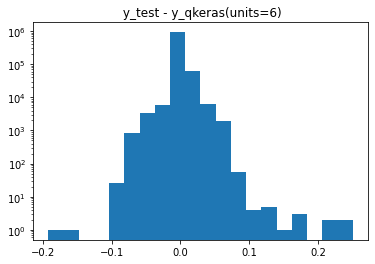

31250/31250 [==============================] - 33s 1ms/step


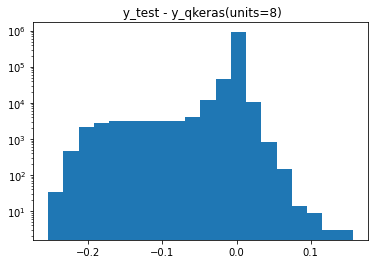

31250/31250 [==============================] - 34s 1ms/step


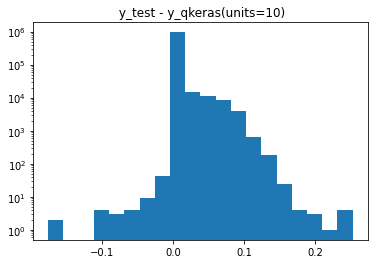

31250/31250 [==============================] - 34s 1ms/step


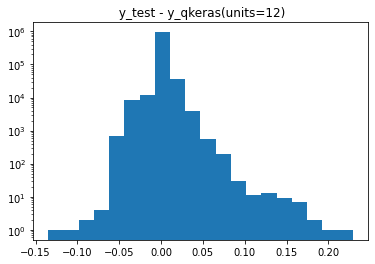

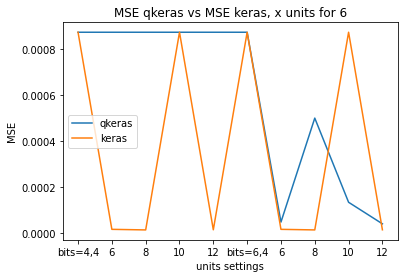

31250/31250 [==============================] - 33s 1ms/step


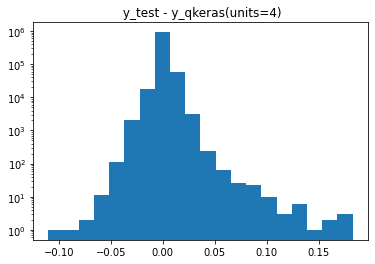

31250/31250 [==============================] - 32s 1ms/step


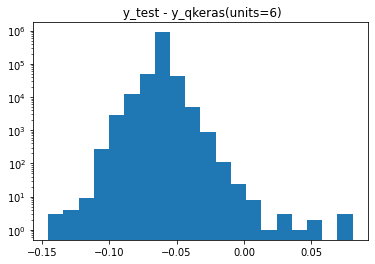

31250/31250 [==============================] - 36s 1ms/step


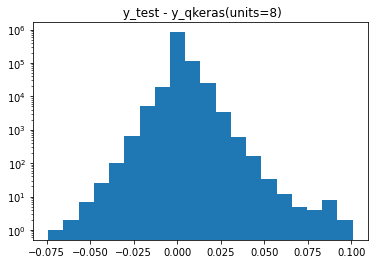

31250/31250 [==============================] - 33s 1ms/step


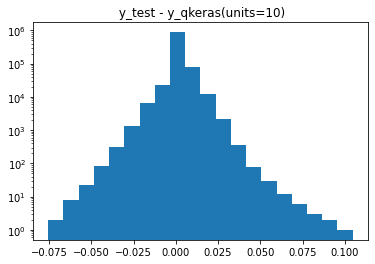

31250/31250 [==============================] - 35s 1ms/step


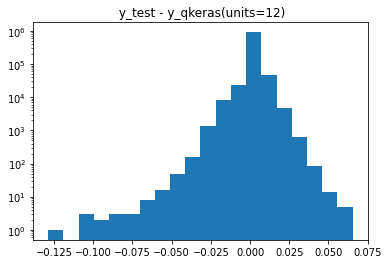

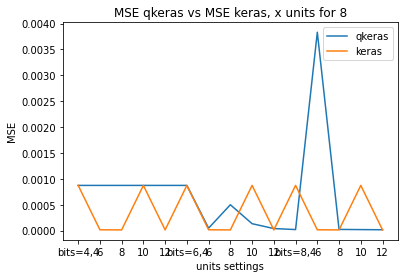

31250/31250 [==============================] - 34s 1ms/step


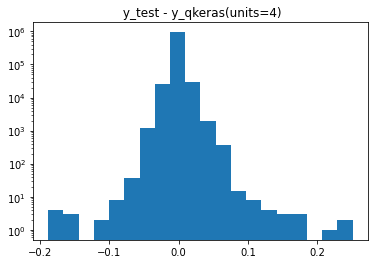

31250/31250 [==============================] - 44s 1ms/step


In [8]:
bit_nbr = []
loss1 = [] 
loss2 = []
unit_nbr = []

for i in range(bits_range):

    bit_nbr.append(bit_lenghts(i))
    for j in range (units_range):
        if (j==0):
            unit_nbr.append(f'bits={bit_lenghts(i)},{units(j)}')
        else: 
            unit_nbr.append(f'{units(j)}')
        qmodel = qkeras.utils.load_qmodel(qmodels_path(j,i))        
        y_qkeras = qmodel.predict(x_test)
        model = tf.keras.models.load_model(models_path(j))
        y_keras = model.predict(x_test)

        loss1.append(mse(y_test,y_qkeras))        
        loss2.append(mse(y_test,y_keras))

        plt.figure()
        plt.hist(y_test-y_qkeras, bins=20)
        plt.yscale('log')
        plt.title(f' y_test - y_qkeras(units={units(j)})')
        plt.show()
        
    plt.figure()
    plt.plot(loss1)
    plt.plot(loss2)
    plt.legend(['qkeras','keras'])
    plt.xticks(np.arange(len(unit_nbr)), [f"{unit}" for unit in unit_nbr])
    plt.xlabel('units settings')
    plt.ylabel('MSE')
    plt.title(f'MSE qkeras vs MSE keras, x units for {bit_lenghts(i)}')
    plt.show()


## Quantization training 

In [ ]:
def quantized_model (bits, units_parameter,):  

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=10, 
                                                    restore_best_weights=True, 
                                                    min_delta=0.000001,
                                                    mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=5, min_lr=0.000001, verbose=1)  
    qr_model = Sequential()

    qr_model.add(QSimpleRNN(units_parameter,
                        input_dim= 1,
                        activation='relu',
                        kernel_quantizer=quantized_bits(**bits),
                        recurrent_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)    
                        ))
       
    qr_model.add(QDense(output, 
                        activation='linear',
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits) ))

    qr_model.compile(loss="mse", optimizer=Adam(lr))
    
    qr_model.summary()

    qr_model.fit(x, y, validation_data= (x_val,y_val),epochs = nbr_epoch, batch_size=40, shuffle=True, callbacks=[early_stopping, reduce_lr])

    return qr_model

def qmodel_training (): 

    qmodels =[]
    for i in range(bits_range):
        bits_parameter = bit_width(i)
        for j in range(units_range):
            units_parameter = units(j)
            qmodel = quantized_model(bits_parameter, units_parameter)
            qmodel.save(qtrained_models_path(j,i))
            qmodels.append(qmodel)
        print( 'bit width ', bits_parameter)        
    return qmodels
        
qmodels = qmodel_training()
        

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_simple_rnn (QSimpleRNN)   (None, 4)                 24        
                                                                 
 q_dense (QDense)            (None, 1)                 5         
                                                                 
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500


/atlas/bonnet/miniconda3/envs/hls4ml-tutorial/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 1697/22500 [=>............................] - ETA: 1:02 - loss: 0.0043

KeyboardInterrupt: 

## Trained network with qkeras

# 3. Compare the results

In [ ]:
loss1 = []
loss2 = []
loss3 = []
bits_nbr = [] 

for i in range(bits_range):
    
    model = qkeras.utils.load_qmodel(qmodels_path(0,i))
    model_ref = qkeras.utils.load_qmodel(f"qmodels_test/qmodels_units={units(0)},<{bit_lenghts(i)},{integer}>.h5")
    bits_nbr.append(bit_lenghts(i))
    y_keras = model.predict(x_test)
    y_qref = model_ref.predict(x_test)
    loss1.append(mse(y_test,y_ref))
    loss2.append(mse(y_test,y_qref))
    loss3.append(mse(y_test,y_keras))

    print ('lossref-loss', (mse(y_test,y_qref)-mse(y_test,y_keras)))
    plt.figure()
    plt.hist(y_test-y_keras, bins=20)
    plt.yscale('log')
    plt.title(f' y_test - y_keras(bits={bit_lenghts(i)}')
    plt.show()

plt.figure()
plt.plot(loss1)
plt.plot(loss2)
plt.plot(loss3)
plt.legend(['ref','qref','qmodel'])
plt.xticks(np.arange(len(bits_nbr)), [f"{bits}" for bits in bits_nbr])
plt.xlabel('bits settings')
plt.ylabel('MSE')
plt.title(f'model trained from scratch, x units')
plt.show()

TypeError: qmodels_path() takes 1 positional argument but 2 were given